In [5]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
import matplotlib.pyplot as plt
from scipy import stats
from scipy import cluster

In [6]:
n = 1000
beta01, beta11 = 5,-3
beta02, beta12 = 2, 4

#set up regression mixture
x1 = np.random.uniform(0, 10, size=400)
x2 = np.random.uniform(0, 10, size=600)

y1 = beta01 + beta11*x1 + np.random.normal(scale=5.0, size=400)
y2 = beta02 + beta12*x2 + np.random.normal(scale=4.0,size=600)

X = np.concatenate([x1, x2])
Y = np.concatenate([y1, y2])


#set up 2 component mixture
a1 = np.random.normal(2, 5, size=600)
a2 = np.random.normal(5, 3, size=400)
a = np.concatenate([a1,a2])

In [7]:
def e_step(y,x,params): 
    y, x = np.array(y), np.array(x)
    nobs, k = x.shape
    weights = []
    for param in params:

        sigma = param[-1]
        beta = np.tile(param[1:-1],nobs).reshape(nobs, k)
        mean = (beta*x).sum(axis=1)
        weights.append( stats.norm.pdf(y, loc=mean, scale=sigma)*param[0] )
        
    #update loop variables
    weights = np.array(weights).transpose()
    #denom = np.repeat( 1+np.exp(weights).sum(axis=1), len(params) ).reshape(nobs,len(params))
    denom = np.repeat(weights.sum(axis=1), len(params) ).reshape(nobs,len(params))
    weights = weights/denom
    return weights, np.log(denom[:,0])
        
    
def m_step(y,x,weights):
    y, x, weights = np.array(y), np.array(x), np.array(weights)
    nobs, k = x.shape
    params, se, err = [], [], 0

    for w in weights.transpose():
        
        lamb = w.mean()
        lamb_se = w.std()

        #beta
        w_mat = np.diag(w)
        xx_mat = np.linalg.inv( x.transpose().dot( w_mat).dot(x) )
        beta = xx_mat.dot(x.transpose().dot(w_mat)).dot(y)
        
        #sigma
        mu = np.tile(beta, nobs).reshape(nobs, k)*x
        weighted_err = w*(y - mu.sum(axis=1))**2
        sigma =  (weighted_err.sum()/w.sum())**.5

        #add component
        comp_param =np.concatenate(([lamb],beta,[sigma]))
        params.append(comp_param)

        #beta_se
        beta_se = (np.diagonal(xx_mat*sigma**2))**.5
        comp_se = np.concatenate(([lamb_se],beta_se))
        se.append(comp_se)

        #SSR
        err = err+weighted_err
    return np.array(params), np.array(se), 1-err.mean()/y.var()


def gen_weights(y,ncomp):
    c,labels = cluster.vq.kmeans2(y,ncomp)
    return np.array(pd.get_dummies(labels))


def estimate(y,x,ncomp):
    e = gen_weights(y,ncomp)
    m = None
    for i in range(15):
        m,se,r2 = m_step(y,x,e)
        e,ll = e_step(y,x,m)
    return m, se, r2, y, x, ncomp, ll


m, se, r2, y, x, ncomp, ll = estimate(Y, sm.add_constant(X), 1)

In [8]:
def write_table(fname, estimates, labels=('y',None)):
    
    #unpack relevant information
    params, se, r2, y, x, ncomp, ll = estimates
    nobs, k = x.shape
    ylabel, xlabel = labels
    
    if xlabel == None:
        xlabel =[]
        for i in range(k):
            xlabel.append('x%s'%i)
            
    assert (k == len(xlabel)) 
    
    f = open(fname, "w+")
    
    f.write(('\\begin{center}  \n'+
            '\\begin{tabular}{lclc} \n'+
            '\\toprule \n'+
            '\\textbf{Dep. Variable:} & %s & \\textbf{  R-squared: } &  %s \\\\ \n'%(ylabel, np.round(r2,3))  ))
    
    f.write(('\\textbf{No. Observations:} & %s & \\textbf{ Log-Likelihood:} & %s \\\\ \n'%(nobs,
                                                                                           np.round(ll.sum(),1))+
            '\end{tabular} \n'))
    
    
    f.write('\n\\begin{tabular}{lcccc} \n')
    for comp in range(ncomp):
        f.write('\\toprule \n')
        f.write('\\textbf{Regime %s} & \\textbf{est} & \\textbf{std err} &'%(1+comp)+ 
                '\\textbf{t} & \\textbf{P $>$ $|$ t $|$} \\\\ \n')
        f.write('\\bottomrule \\\\ \n')
        
        #isolate params
        comp_params = params[comp]
        comp_se = se[comp]
        comp_t = comp_params[:-1]/comp_se
        comp_p = 1 - stats.t.cdf(np.abs(comp_t),df=(nobs-k)) + stats.t.cdf(-np.abs(comp_t),df=(nobs-k))
        
        #round everything
        comp_params = np.round(comp_params,5)
        comp_se = np.round(comp_se,5)
        comp_t = np.round(comp_t,5)
        comp_p = np.round(comp_p,5)
        
        lamb = comp_params[0]
        #lamb_se, lamb_t, lamb_p = comp_params[0], comp_se[0], comp_t[0], comp_p[0]
        beta, beta_se, beta_t, beta_p = comp_params[1:-1], comp_se[1:], comp_t[1:], comp_p[1:]
        sigma = comp_params[-1]
        
        if ncomp > 1:
            f.write('\\textbf{lambda} & %s  & & & \\\\ \\\\ \n'%(lamb) )
        
        for i in range(k):
            f.write('\\textbf{%s} & %s & (%s) & %s & %s \\\\ \\\\ \n'%(xlabel[i],beta[i],beta_se[i],
                                                                             beta_t[i],beta_p[i]) )
        
        f.write('\\textbf{sigma} & %s &  & & \\\\ \\\\ \n'%(sigma) )
    
    f.write('\end{tabular} \n'+
            '\end{center}\n')
    f.close()
    
    #print output
    f = open(fname, "r")
    print f.read()
    f.close()

In [12]:
rawdata = pd.read_csv('data/milk.csv')
data = rawdata.copy()

#general house keeping
data = data[ (data['YEAR']>=1980) & (data['MONTH'] !=0) ]
data = data.sort_values(['YEAR','MONTH','DAY'])
data['COOLER'] = data['COOLER'].fillna(0)
data['ESC'] = data['ESC'].fillna(0)


#various keys
milk =  ['WW','LFW','WC','LFC']
auct_key = ['YEAR','MONTH','DAY','SYSTEM','FMOZONE']
cts = ['FMO','GAS','POPUL','QWW']
dummies = ['COOLER','ESC']


#baseline stuff/logs
lmilk = ['L'+x for x in milk]
lcts = ['L'+x for x in cts]
data[lcts] = np.log(data[cts])
data[lmilk] = np.log(data[milk])


#set up fixed effects
fe = ['FMOZONE']
#fe = []
fekeys = []
for effect in fe:
    fes = pd.get_dummies(data[effect],drop_first=True)
    fekeys = fekeys+ list(fes.columns)
    data = pd.concat((data, fes), axis=1)


covariates = dummies+lcts+fekeys
covariates_hist =  covariates + lagkeys

reg1 = data[['LWW']+covariates_hist]
reg1 = reg1.dropna()


#set up lags
lags = 5
lagkeys = [l+str(i) for l in ['LWW_min','LWW_max'] for i in range(1,1+lags)]
aucts = data.groupby(auct_key, as_index=False)[milk].mean()[auct_key]

for i in range(1,1+lags):

    max_lag = data.groupby(auct_key, as_index=False).max()[lmilk]
    print max_lag.loc[20]
    max_lag = max_lag.shift(i)[lmilk]
    print max_lag.loc[21]
    max_lag = pd.concat((aucts, max_lag), axis=1)
    
    data = pd.merge(data, max_lag, how='left', on=auct_key, suffixes=('', '_max%s'%(i) ) )
    print data[ (data['YEAR']==1985) & (data['SYSTEM']=='ALEDO')]['LWW']
    print '---'
    print data[ (data['YEAR']==1984) & (data['SYSTEM']=='ALEDO')]['LWW']
    print '---'
    print data[ (data['YEAR']==1985) & (data['SYSTEM']=='ALEDO')]['LWW_max1']
    #print data[ (data['YEAR']==1985) & (data['SYSTEM']=='ALEDO')]['LWWW_max1']
    break 
    
    min_lag = data.groupby(auct_key, as_index=False)[lmilk].min()
    min_lag = min_lag.shift(i)[lmilk]
    min_lag = pd.concat((aucts, min_lag), axis=1)
    data = pd.merge(data, min_lag, how='left', on=auct_key, suffixes=('', '_min%s'%(i)) )    
    



reg1.to_csv('data/clean_milk.csv',index=False)

#print sm.OLS(reg1['LWW'],sm.add_constant(reg1[covariates_hist])).fit().summary()

LWW    -1.714798
LLFW         NaN
LWC          NaN
LLFC         NaN
Name: 20, dtype: float64
LWW    -1.714798
LLFW         NaN
LWC          NaN
LLFC         NaN
Name: 21, dtype: float64
1555   -1.897120
1556   -1.742969
1557   -1.820159
Name: LWW, dtype: float64
---
1108   -1.795767
Name: LWW, dtype: float64
---
1555   -1.771957
1556   -1.771957
1557   -1.771957
Name: LWW_max1, dtype: float64


KeyError: "['LWW_min1' 'LWW_min2' 'LWW_min3' 'LWW_min4' 'LWW_min5' 'LWW_max2'\n 'LWW_max3' 'LWW_max4' 'LWW_max5'] not in index"

In [48]:
est0 = estimate(reg1['LWW'],sm.add_constant(reg1[covariates]),1)
write_table('results/ols_results.tex', est0, labels=('LWW', ['const']+covariates))

\begin{center}  
\begin{tabular}{lclc} 
\toprule 
\textbf{Dep. Variable:} & LWW & \textbf{  R-squared: } &  0.151 \\ 
\textbf{No. Observations:} & 3071 & \textbf{ Log-Likelihood:} & 3411.4 \\ 
\end{tabular} 

\begin{tabular}{lcccc} 
\toprule 
\textbf{Regime 1} & \textbf{est} & \textbf{std err} &\textbf{t} & \textbf{P $>$ $|$ t $|$} \\ 
\bottomrule \\ 
\textbf{const} & -2.32427 & (0.07935) & -29.29217 & 0.0 \\ \\ 
\textbf{COOLER} & 0.01565 & (0.0032) & 4.8983 & 0.0 \\ \\ 
\textbf{ESC} & -0.02762 & (0.00304) & -9.07794 & 0.0 \\ \\ 
\textbf{LFMO} & 0.19578 & (0.0296) & 6.61388 & 0.0 \\ \\ 
\textbf{LGAS} & 0.01069 & (0.00444) & 2.41035 & 0.016 \\ \\ 
\textbf{LPOPUL} & 0.00713 & (0.002) & 3.57134 & 0.00036 \\ \\ 
\textbf{LQWW} & -0.00423 & (0.00216) & -1.96142 & 0.04992 \\ \\ 
\textbf{1A} & -0.02195 & (0.02074) & -1.05844 & 0.28994 \\ \\ 
\textbf{3} & -0.06895 & (0.00462) & -14.92237 & 0.0 \\ \\ 
\textbf{6} & -0.05238 & (0.00794) & -6.59649 & 0.0 \\ \\ 
\textbf{7} & -0.10367 & (0.01512) & -

/home/erichschulman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide


In [49]:
est1 = estimate(reg1['LWW'],sm.add_constant(reg1[covariates_hist]),1)
write_table('results/hist_results.tex', est1, labels=('LWW', ['const']+covariates_hist))

\begin{center}  
\begin{tabular}{lclc} 
\toprule 
\textbf{Dep. Variable:} & LWW & \textbf{  R-squared: } &  0.201 \\ 
\textbf{No. Observations:} & 3071 & \textbf{ Log-Likelihood:} & 3504.9 \\ 
\end{tabular} 

\begin{tabular}{lcccc} 
\toprule 
\textbf{Regime 1} & \textbf{est} & \textbf{std err} &\textbf{t} & \textbf{P $>$ $|$ t $|$} \\ 
\bottomrule \\ 
\textbf{const} & -1.91191 & (0.09393) & -20.35406 & 0.0 \\ \\ 
\textbf{COOLER} & 0.00999 & (0.00314) & 3.18222 & 0.00148 \\ \\ 
\textbf{ESC} & -0.02413 & (0.00297) & -8.11714 & 0.0 \\ \\ 
\textbf{LFMO} & 0.23196 & (0.02907) & 7.98047 & 0.0 \\ \\ 
\textbf{LGAS} & 0.00871 & (0.0044) & 1.9781 & 0.04801 \\ \\ 
\textbf{LPOPUL} & 0.00518 & (0.00195) & 2.65471 & 0.00798 \\ \\ 
\textbf{LQWW} & -0.00305 & (0.00212) & -1.44184 & 0.14945 \\ \\ 
\textbf{1A} & -0.01435 & (0.02015) & -0.71218 & 0.47641 \\ \\ 
\textbf{3} & -0.05563 & (0.00462) & -12.05235 & 0.0 \\ \\ 
\textbf{6} & -0.04917 & (0.00781) & -6.29491 & 0.0 \\ \\ 
\textbf{7} & -0.07155 & (0.0

/home/erichschulman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in divide


In [50]:
est2 = estimate(reg1['LWW'],sm.add_constant(reg1[covariates]),2)
write_table('results/prelim_results.tex', est2, labels=('LWW', ['const']+covariates))

\begin{center}  
\begin{tabular}{lclc} 
\toprule 
\textbf{Dep. Variable:} & LWW & \textbf{  R-squared: } &  0.443 \\ 
\textbf{No. Observations:} & 3071 & \textbf{ Log-Likelihood:} & 3654.4 \\ 
\end{tabular} 

\begin{tabular}{lcccc} 
\toprule 
\textbf{Regime 1} & \textbf{est} & \textbf{std err} &\textbf{t} & \textbf{P $>$ $|$ t $|$} \\ 
\bottomrule \\ 
\textbf{lambda} & 0.70093  & & & \\ \\ 
\textbf{const} & -2.10651 & (0.08471) & -24.866 & 0.0 \\ \\ 
\textbf{COOLER} & 0.01019 & (0.00338) & 3.01382 & 0.0026 \\ \\ 
\textbf{ESC} & -0.03185 & (0.00327) & -9.72636 & 0.0 \\ \\ 
\textbf{LFMO} & 0.13438 & (0.03167) & 4.2437 & 2e-05 \\ \\ 
\textbf{LGAS} & -0.0095 & (0.00468) & -2.0301 & 0.04243 \\ \\ 
\textbf{LPOPUL} & 0.0095 & (0.00205) & 4.62939 & 0.0 \\ \\ 
\textbf{LQWW} & -0.0049 & (0.00222) & -2.21021 & 0.02716 \\ \\ 
\textbf{1A} & -0.04266 & (0.0234) & -1.82312 & 0.06838 \\ \\ 
\textbf{3} & -0.03404 & (0.00488) & -6.97766 & 0.0 \\ \\ 
\textbf{6} & -0.00773 & (0.00852) & -0.90788 & 0.36401

In [52]:
test1 = estimate(Y, sm.add_constant(X), 2)
test2 = estimate(Y, sm.add_constant(X), 1)

def nonnested_test(model1,model2):
    """test for non nested models quang vuong"""
    
    params1, se1, r21, y1, x1, ncomp1, ll1 = model1
    params2, se2, r22, y2, x2, ncomp2, ll2 = model2
    nobs, k = x1.shape
    
    k1 = params1.shape[1]*ncomp1 - 1 
    k2 = params2.shape[1]*ncomp2 - 1
    
    var1 = (ll1 -ll2).std()
    test1 = (ll1.sum() - ll2.sum() - k1 + k2)*nobs**(-.5)
    test1 = test1/var1
    p1 = 1 - stats.t.cdf(np.abs(test1),df=(nobs-k1-k2)) + stats.t.cdf(-np.abs(test1),df=(nobs-k1-k2))
    
    var2 =  ((ll1 - ll2)**2).mean()**.5
    test2 = (ll1.sum() - ll2.sum() - k1 + k2 )*nobs**(-.5)
    test2 = test2/var2
    p2 = 1 - stats.t.cdf(np.abs(test2),df=(nobs-k1-k2)) + stats.t.cdf(-np.abs(test2),df=(nobs-k1-k2))
    
    
    
    #f.write('\end{tabular} \n'+
    #        '\end{center}\n')
    #f.close()
    
    return test1, test2, p1, p2

print nonnested_test(est2,est1)

(4.5219372881153514, 4.506126572405065, 6.3634204035560885e-06, 6.8527940286925365e-06)


(4004,)


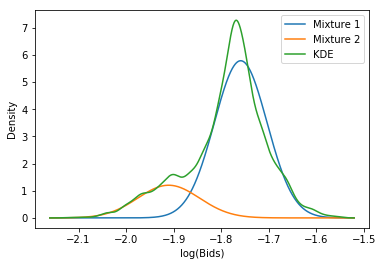

In [45]:
rawdata = pd.read_csv('data/milk.csv')
data= rawdata.copy()

bids = np.array(data['WW'].dropna())
lbids = np.log(bids[ (bids >= .12) &(bids<=.21)])

print lbids.shape

#do KDE
dens = sm.nonparametric.KDEUnivariate(lbids)
dens.fit()

# do Guasian mixture
est = estimate(lbids,np.ones((len(lbids),1)) , 2)
coefs = est[0]
comp1 = coefs[0,0]*stats.norm.pdf(dens.support,coefs[0,1],coefs[0,2])
comp2 = coefs[1,0]*stats.norm.pdf(dens.support,coefs[1,1],coefs[1,2])


plt.plot(dens.support, comp1, label='Mixture 1')
plt.plot(dens.support, comp2, label='Mixture 2')
plt.xlabel('log(Bids)')
plt.ylabel('Density')
plt.plot(dens.support, dens.density, label='KDE')
plt.legend()
plt.savefig('results/bid_mixture.png')
plt.show()